## No Domain Adaptation (MVE-Only) Run

In this notebook, we run mean-variance estimation (MVE) with NO domain adaptation (DA). This is MVE-only. All notebooks are identical, except for 2 changes, as specified below. MVE-only runs have a DA Weight of 0.0 in the loss function, meaning the MMD Loss is not used in training.

**NOTE:**  
SEED - Seed will change between Runs (Run A, B, C, D, E), but is consistent across MVE-only and MVE-UDA.  
DA Weight - DA Weight is 1.4 for MVE-UDA runs. DA Weight is 0.0 for MVE-only runs.

In [1]:
# Imports we will use
import torch
import gc
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Function
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import random
from pathlib import Path
from sklearn.metrics import r2_score
from astropy.visualization import make_lupton_rgb
from sklearn.manifold import Isomap
from train_utils import *
import time
import os
import json

%matplotlib inline
plt.rcParams.update({'font.size': 12})

# Find if cuda is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


### Set Seed

Seed is set according to run index. Specifically,
* Run A: Seed 56
* Run B: Seed 11
* Run C: Seed 31
* Run D: Seed 6
* Run E: Seed 63

In [2]:
#fix seed
seed = 63
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.enabled=False
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(seed)

## Load Data

In [3]:
# Specify paths, load in data, and subsample labels
head = Path.cwd().parents[1]
source_img_path = head / 'data/mb_paper_source_final/mb_paper_source_final.npy'
target_img_path = head / 'data/mb_paper_target_final/mb_paper_target_final.npy'
source_meta = head / 'data/mb_paper_source_final/mb_paper_source_final_metadata.csv'
target_meta = head / 'data/mb_paper_target_final/mb_paper_target_final_metadata.csv'
batch_size = 128
source_train_dataloader, source_test_dataloader, source_val_dataloader, source_data = create_dataloader(source_img_path, source_meta, batch_size)
target_train_dataloader, target_test_dataloader, target_val_dataloader, target_data = create_dataloader(target_img_path, target_meta, batch_size)
isomap_source_label_sample = pd.read_csv(source_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]
isomap_target_label_sample = pd.read_csv(target_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]

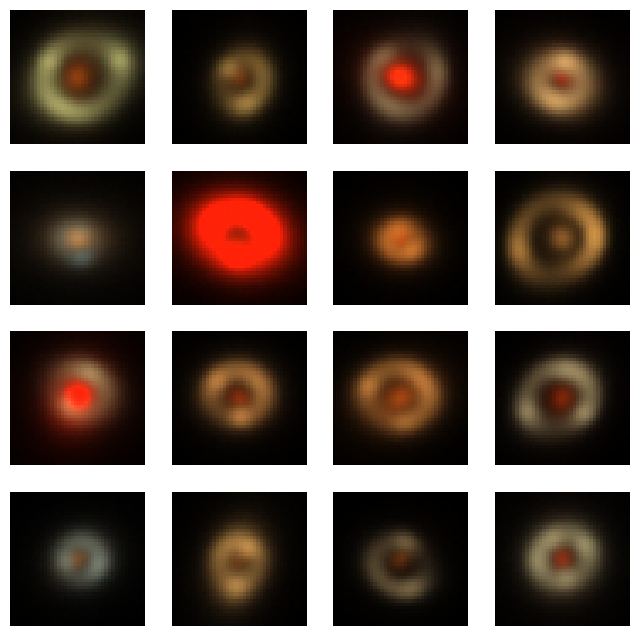

In [4]:
# Visualize source data
visualize_data(source_data)

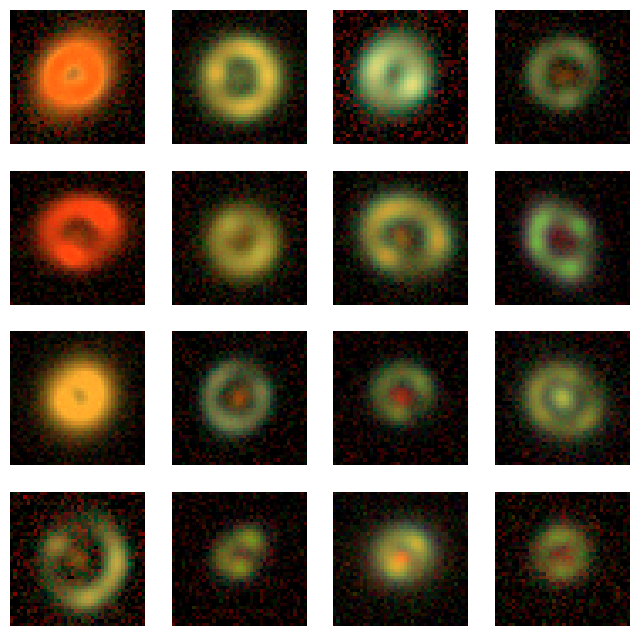

In [5]:
# Visualize target data
visualize_data(target_data)

## Model Setup

DA Weight is set according to MVE-Only or MVE-UDA run. Specifically,  
* MVE-UDA: DA Weight = constant 1.4
* MVE-only: DA Weight = constant 0.0, i.e. NO DA Loss

In [6]:
# Choose how you prefer to evolve beta and the DA Weight
def da_weight_function(epoch):
    """ Linear evolving DA weighting in loss function. """
    # if epoch < evolv_epoch:
    #     da_weight = init_wt_da - ((init_wt_da - final_wt_da) * (epoch / n_epoch))
    # else:
    #     da_weight = final_wt_da
    return 0.0

def beta_function(epoch):
    """ Linear evolving beta weighting in loss function until halfway through total epochs. """
    # if epoch < evolv_epoch:
    #     beta_val = beta_init - (beta_init - beta_final) * (epoch / evolv_epoch)
    # else:
    #     beta_val = beta_final
    return 0.5

# Initialize hyperparameters
n_epoch = 150


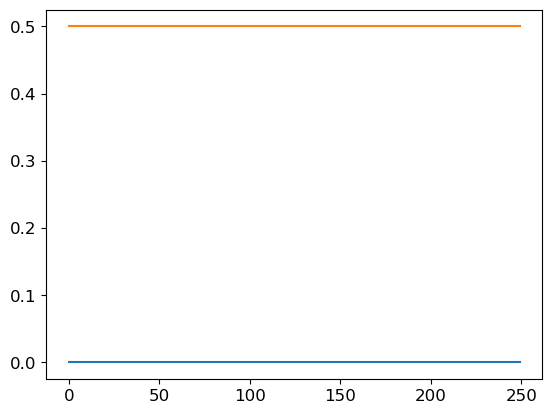

In [7]:
s = np.arange(250)
plt.plot(s, [da_weight_function(i) for i in s])
plt.plot(s, [beta_function(i) for i in s])

### Initialize the Model

Model architecture (MVEv3) is identical to architecture in the paper and summarized below.

In [8]:
# Initialize model
model = NeuralNetworkMVEv3(npix=40).cuda()

# Loss Functions / Optimizers
regressor_loss_fn = nn.MSELoss().cuda()
da_loss_fn = MMD_loss()
optimizer = torch.optim.AdamW(model.parameters())

In [9]:
from torchsummary import summary
summary(model, (3, 40, 40))

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 40, 40]             224
              ReLU-2            [-1, 8, 40, 40]               0
       BatchNorm2d-3            [-1, 8, 40, 40]              16
         MaxPool2d-4            [-1, 8, 20, 20]               0
            Conv2d-5           [-1, 16, 20, 20]           1,168
              ReLU-6           [-1, 16, 20, 20]               0
       BatchNorm2d-7           [-1, 16, 20, 20]              32
         MaxPool2d-8           [-1, 16, 10, 10]               0
            Conv2d-9           [-1, 32, 10, 10]           4,640
             ReLU-10           [-1, 32, 10, 10]               0
      BatchNorm2d-11           [-1, 32, 10, 10]              64
        MaxPool2d-12             [-1, 32, 5, 5]               0
           Linear-13                  [-1, 128]         102,528
          Sigmoid-14                  [

### Initialize Model State

If loading a paused run, enter a `load_mod_name`. If not, leave None, and the state will be initialized automatically.  
`save_mod_name` describes what root name models will be saved under during training.

In [10]:
# To continue training from a past model, enter path into load_mod_name
# Else, enter None, and you still have to run the function.
# Then, enter save_mod_name to save for the current run  

load_mod_name = None 
stats, model, optimizer, best_target_R2, best_mve_loss, best_nll_loss, best_snll_loss = initialize_state(load_mod_name, model, optimizer)


#save_mod_name = load_mod_name # may overwrite loaded model
save_mod_name = "models/RunE_noDA"

## Train

Beginning Training...
Generating Isomap...


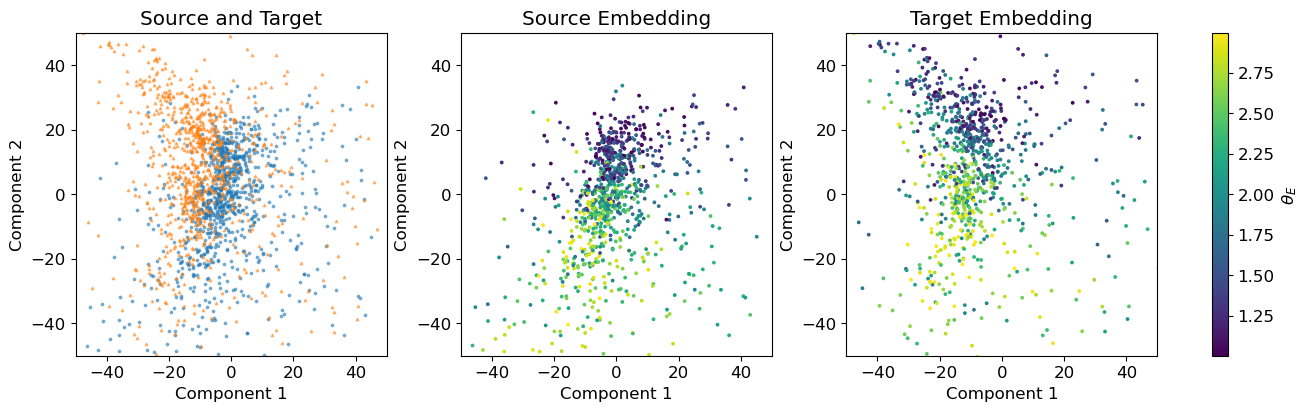

Saving Model... Done.

Epoch 0: 23.36s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0732
	Train Regression Loss: : 0.1187
	Train Mve Loss: : -0.1619
	Train R2 Score: : 0.6392
 Validation Statistics:
	Val Source Regression Loss: : 0.0234
	Val Target Regression Loss: : 0.0266
	Val Source R2 Score: : 0.9281
	Val Target R2 Score: : 0.9210
	Val Source Mve Loss: : -0.2681
	Val Target Mve Loss: : -0.2657
	Val Source Nll Loss: : -0.4315
	Val Target Nll Loss: : -0.4283
Saving Model... Done.
Saving Model MVE... Done.
Saving Model NLL... Done.
Saving Model SNLL... Done.

Epoch 1: 23.44s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0599
	Train Regression Loss: : 0.0620
	Train Mve Loss: : -0.1654
	Train R2 Score: : 0.8129
 Validation Statistics:
	Val Source Regression Loss: : 0.0605
	Val Target Regression Loss: : 0.0672
	Val Source R2 Score: : 0.8154
	Val Target R2 Score: : 0.8001
	Val Source Mve Loss: : -0.1344
	Val Target Mve Loss: : -0.13

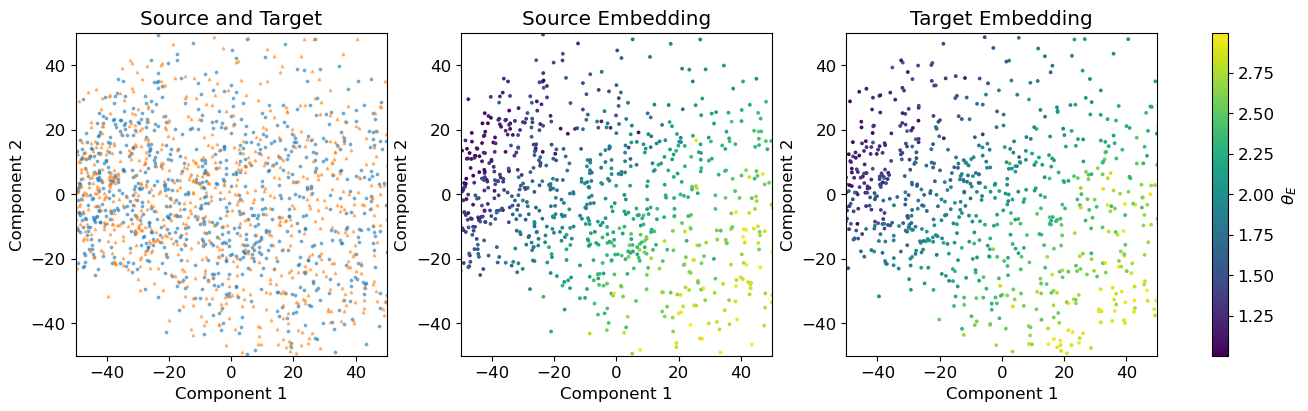

Saving Model... Done.
Saving Model... Done.

Epoch 20: 21.56s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0603
	Train Regression Loss: : 0.0024
	Train Mve Loss: : -0.1745
	Train R2 Score: : 0.9926
 Validation Statistics:
	Val Source Regression Loss: : 0.0024
	Val Target Regression Loss: : 0.0040
	Val Source R2 Score: : 0.9927
	Val Target R2 Score: : 0.9882
	Val Source Mve Loss: : -0.1134
	Val Target Mve Loss: : -0.0961
	Val Source Nll Loss: : -2.5244
	Val Target Nll Loss: : -2.0932
Saving Model... Done.
Saving Model NLL... Done.
Saving Model SNLL... Done.

Epoch 21: 21.05s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0585
	Train Regression Loss: : 0.0019
	Train Mve Loss: : -0.1358
	Train R2 Score: : 0.9941
 Validation Statistics:
	Val Source Regression Loss: : 0.0015
	Val Target Regression Loss: : 0.0043
	Val Source R2 Score: : 0.9953
	Val Target R2 Score: : 0.9872
	Val Source Mve Loss: : -0.1173
	Val Target Mve Loss: : -0.0857

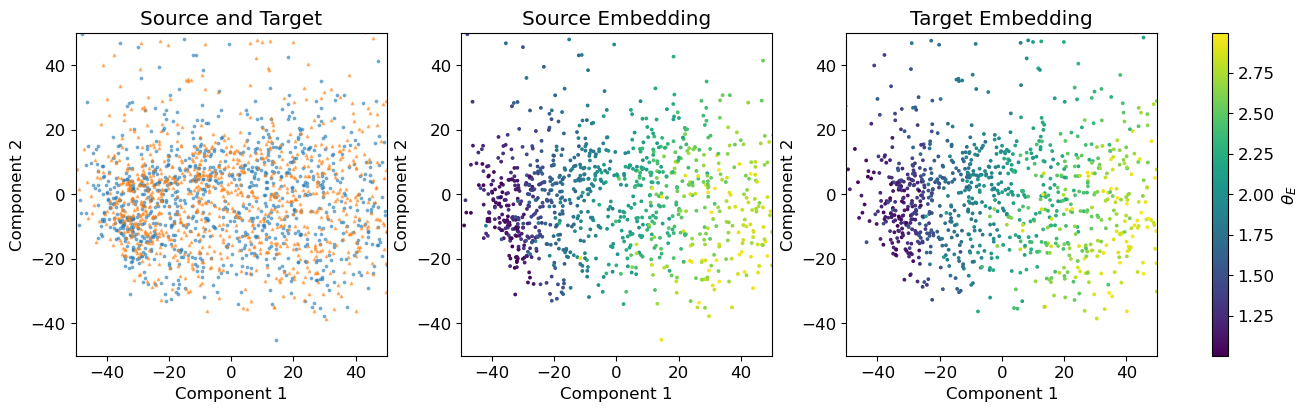

Saving Model... Done.

Epoch 40: 23.74s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0605
	Train Regression Loss: : 0.0011
	Train Mve Loss: : -0.0983
	Train R2 Score: : 0.9966
 Validation Statistics:
	Val Source Regression Loss: : 0.0010
	Val Target Regression Loss: : 0.0040
	Val Source R2 Score: : 0.9970
	Val Target R2 Score: : 0.9882
	Val Source Mve Loss: : -0.1053
	Val Target Mve Loss: : -0.0642
	Val Source Nll Loss: : -2.9630
	Val Target Nll Loss: : -1.8079
Saving Model SNLL... Done.

Epoch 41: 23.68s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0600
	Train Regression Loss: : 0.0010
	Train Mve Loss: : -0.1469
	Train R2 Score: : 0.9971
 Validation Statistics:
	Val Source Regression Loss: : 0.0521
	Val Target Regression Loss: : 0.0491
	Val Source R2 Score: : 0.8399
	Val Target R2 Score: : 0.8524
	Val Source Mve Loss: : -0.1202
	Val Target Mve Loss: : -0.1299
	Val Source Nll Loss: : -0.7420
	Val Target Nll Loss: : -0.8042

Epoc

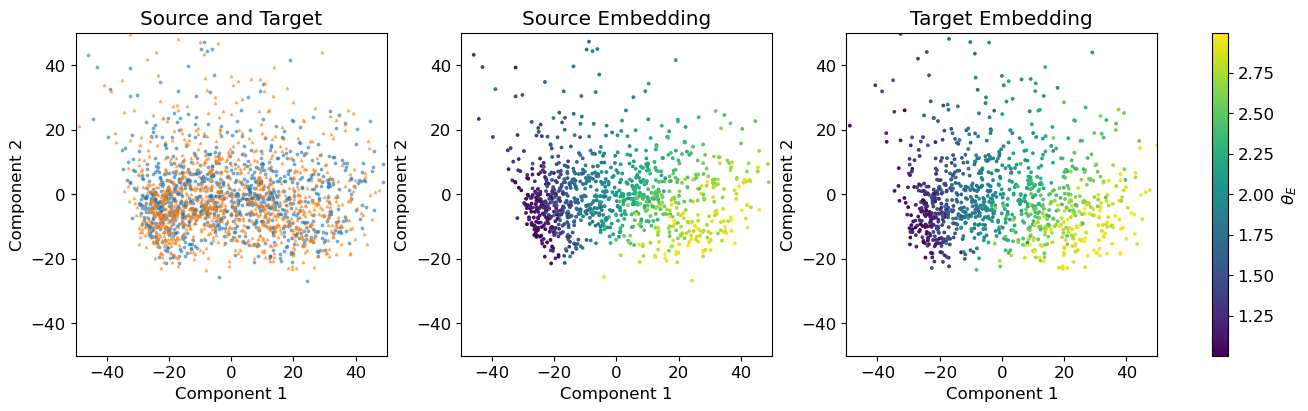

Saving Model... Done.

Epoch 60: 21.37s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0762
	Train Regression Loss: : 0.0010
	Train Mve Loss: : -0.1010
	Train R2 Score: : 0.9969
 Validation Statistics:
	Val Source Regression Loss: : 0.0009
	Val Target Regression Loss: : 0.0045
	Val Source R2 Score: : 0.9974
	Val Target R2 Score: : 0.9864
	Val Source Mve Loss: : -0.0964
	Val Target Mve Loss: : -0.0649
	Val Source Nll Loss: : -3.0766
	Val Target Nll Loss: : -2.0179

Epoch 61: 21.24s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0754
	Train Regression Loss: : 0.0015
	Train Mve Loss: : -0.2503
	Train R2 Score: : 0.9953
 Validation Statistics:
	Val Source Regression Loss: : 0.0016
	Val Target Regression Loss: : 0.0035
	Val Source R2 Score: : 0.9951
	Val Target R2 Score: : 0.9895
	Val Source Mve Loss: : -0.2422
	Val Target Mve Loss: : -0.2342
	Val Source Nll Loss: : -2.1030
	Val Target Nll Loss: : -2.0287

Epoch 62: 21.35s
--------------

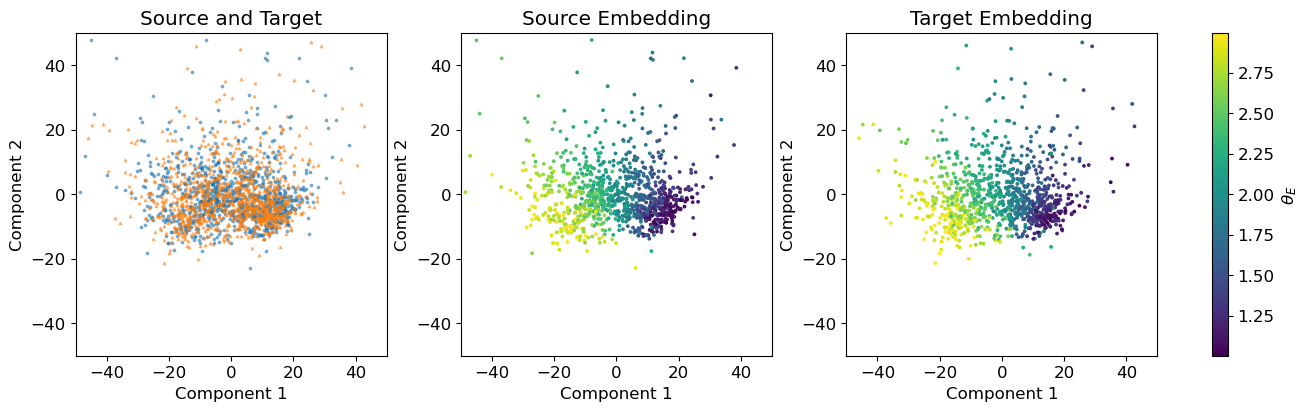

Saving Model... Done.

Epoch 80: 23.95s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0568
	Train Regression Loss: : 0.0016
	Train Mve Loss: : -0.3607
	Train R2 Score: : 0.9952
 Validation Statistics:
	Val Source Regression Loss: : 0.0016
	Val Target Regression Loss: : 0.0027
	Val Source R2 Score: : 0.9950
	Val Target R2 Score: : 0.9919
	Val Source Mve Loss: : -0.3549
	Val Target Mve Loss: : -0.3530
	Val Source Nll Loss: : -1.2379
	Val Target Nll Loss: : -1.2303

Epoch 81: 21.35s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0584
	Train Regression Loss: : 0.0014
	Train Mve Loss: : -0.3327
	Train R2 Score: : 0.9957
 Validation Statistics:
	Val Source Regression Loss: : 0.0014
	Val Target Regression Loss: : 0.0027
	Val Source R2 Score: : 0.9957
	Val Target R2 Score: : 0.9919
	Val Source Mve Loss: : -0.2823
	Val Target Mve Loss: : -0.2780
	Val Source Nll Loss: : -1.8485
	Val Target Nll Loss: : -1.8186

Epoch 82: 21.24s
--------------

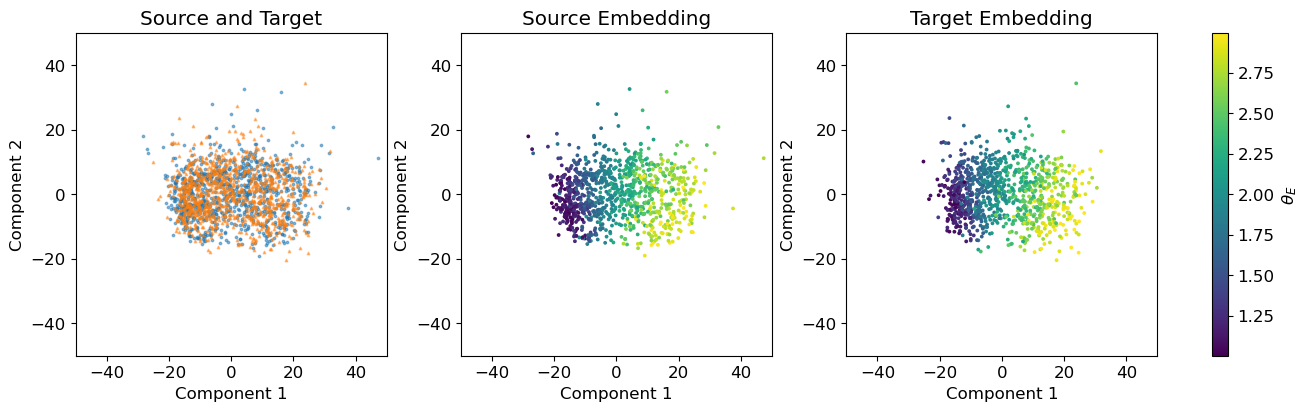

Saving Model... Done.

Epoch 100: 21.50s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0613
	Train Regression Loss: : 0.0006
	Train Mve Loss: : -0.0833
	Train R2 Score: : 0.9981
 Validation Statistics:
	Val Source Regression Loss: : 0.0007
	Val Target Regression Loss: : 0.0024
	Val Source R2 Score: : 0.9978
	Val Target R2 Score: : 0.9930
	Val Source Mve Loss: : -0.0932
	Val Target Mve Loss: : -0.0682
	Val Source Nll Loss: : -3.1224
	Val Target Nll Loss: : -2.2631

Epoch 101: 21.92s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0598
	Train Regression Loss: : 0.0019
	Train Mve Loss: : -0.3538
	Train R2 Score: : 0.9942
 Validation Statistics:
	Val Source Regression Loss: : 0.0010
	Val Target Regression Loss: : 0.0017
	Val Source R2 Score: : 0.9968
	Val Target R2 Score: : 0.9951
	Val Source Mve Loss: : -0.3509
	Val Target Mve Loss: : -0.3498
	Val Source Nll Loss: : -1.3057
	Val Target Nll Loss: : -1.3000

Epoch 102: 23.51s
-----------

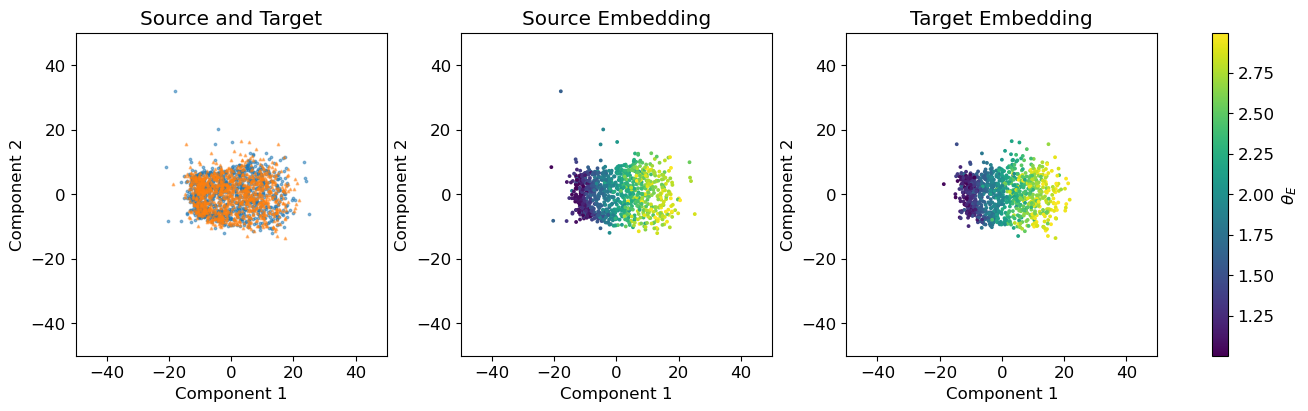

Saving Model... Done.

Epoch 120: 23.37s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0508
	Train Regression Loss: : 0.0017
	Train Mve Loss: : -0.2885
	Train R2 Score: : 0.9948
 Validation Statistics:
	Val Source Regression Loss: : 0.0007
	Val Target Regression Loss: : 0.0012
	Val Source R2 Score: : 0.9977
	Val Target R2 Score: : 0.9964
	Val Source Mve Loss: : -0.2664
	Val Target Mve Loss: : -0.2647
	Val Source Nll Loss: : -1.9897
	Val Target Nll Loss: : -1.9754

Epoch 121: 23.76s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0510
	Train Regression Loss: : 0.0017
	Train Mve Loss: : -0.2063
	Train R2 Score: : 0.9948
 Validation Statistics:
	Val Source Regression Loss: : 0.0021
	Val Target Regression Loss: : 0.0024
	Val Source R2 Score: : 0.9937
	Val Target R2 Score: : 0.9928
	Val Source Mve Loss: : -0.3370
	Val Target Mve Loss: : -0.3363
	Val Source Nll Loss: : -1.4197
	Val Target Nll Loss: : -1.4157

Epoch 122: 23.33s
-----------

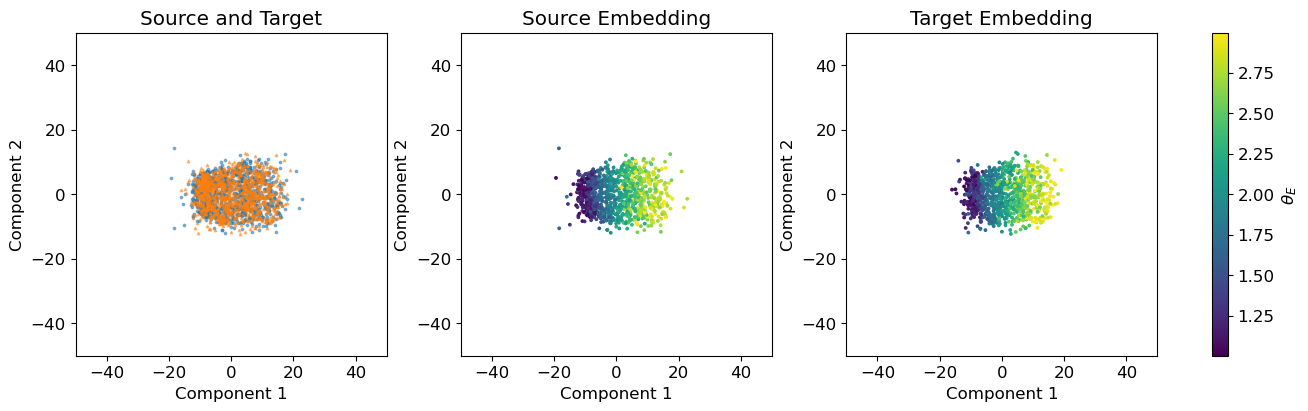

Saving Model... Done.

Epoch 140: 23.50s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0496
	Train Regression Loss: : 0.0013
	Train Mve Loss: : -0.2458
	Train R2 Score: : 0.9961
 Validation Statistics:
	Val Source Regression Loss: : 0.0011
	Val Target Regression Loss: : 0.0015
	Val Source R2 Score: : 0.9966
	Val Target R2 Score: : 0.9955
	Val Source Mve Loss: : -0.3144
	Val Target Mve Loss: : -0.3132
	Val Source Nll Loss: : -1.6319
	Val Target Nll Loss: : -1.6263

Epoch 141: 23.77s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0527
	Train Regression Loss: : 0.0019
	Train Mve Loss: : -0.2297
	Train R2 Score: : 0.9942
 Validation Statistics:
	Val Source Regression Loss: : 0.0014
	Val Target Regression Loss: : 0.0032
	Val Source R2 Score: : 0.9956
	Val Target R2 Score: : 0.9904
	Val Source Mve Loss: : -0.3642
	Val Target Mve Loss: : -0.3614
	Val Source Nll Loss: : -1.0776
	Val Target Nll Loss: : -1.0714

Epoch 142: 23.66s
-----------

In [11]:
print("Beginning Training...")

for curr_epoch in range(stats['epoch_no'], stats['epoch_no'] + n_epoch):

        # Generate isomaps every 20 epochs
        if (curr_epoch % 20 == 0):
            print("Generating Isomap...")
            source_iso, target_iso = generate_isomaps(source_data, target_data, model)
            show_isomaps(source_iso, 
                         target_iso, 
                         isomap_source_label_sample, 
                         isomap_target_label_sample, 
                         save_mod_name, 
                         name = stats["epoch_no"], 
                         axlim = 50, save = True)
            
            print("Saving Model...", end = ' ')
            save_model(save_mod_name + "_{}".format(curr_epoch), model, optimizer, stats)
            print("Done.")

        # Save best models
        if (len(stats['val_target_r2_score']) > 0):
            
            # Save and overwrite model every best target R2
            if (stats['val_target_r2_score'][-1] > best_target_R2):
                print("Saving Model...", end = ' ')
                save_model(save_mod_name, model, optimizer, stats)
                best_target_R2 = stats['val_target_r2_score'][-1]
                print("Done.")
                
            # Save and overwrite model every best target MVE Loss
            if (stats['val_target_mve_loss'][-1] < best_mve_loss):
                print("Saving Model MVE...", end = ' ')
                mve_name = save_mod_name + "_mve"
                save_model(mve_name, model, optimizer, stats)
                best_mve_loss = stats['val_target_mve_loss'][-1]
                print("Done.")

            # Save and overwrite model every best target MVE Loss
            if (stats['val_target_nll_loss'][-1] < best_nll_loss):
                print("Saving Model NLL...", end = ' ')
                nll_name = save_mod_name + "_nll"
                save_model(nll_name, model, optimizer, stats)
                best_nll_loss = stats['val_target_nll_loss'][-1]
                print("Done.")

            # Save and overwrite model every best target MVE Loss
            if (stats['val_source_nll_loss'][-1] < best_snll_loss):
                print("Saving Model SNLL...", end = ' ')
                snll_name = save_mod_name + "_snll"
                save_model(snll_name, model, optimizer, stats)
                best_snll_loss = stats['val_source_nll_loss'][-1]
                print("Done.")
        
        start_time = time.time()

        beta = beta_function(curr_epoch)
        da_weight = da_weight_function(curr_epoch)

        # Train, backpropagate
        vals = train_loop_mve(source_train_dataloader, 
                              target_train_dataloader, 
                              model,
                              regressor_loss_fn, 
                              da_loss_fn, 
                              optimizer,
                              da_weight, 
                              beta)

        # Test, validate metrics
        vals_validate = test_loop_mve(source_val_dataloader, 
                                      target_val_dataloader,
                                      model, 
                                      regressor_loss_fn, 
                                      beta)


        # Training Metrics
        stats['train_DA_loss'].append(vals[0])
        stats['train_regression_loss'].append(vals[1])
        stats['train_mve_loss'].append(vals[2])
        stats['train_r2_score'].append(vals[3])

        # Validation Metrics
        stats['val_source_regression_loss'].append(vals_validate[0])
        stats['val_target_regression_loss'].append(vals_validate[1])
        stats['val_source_r2_score'].append(vals_validate[2])
        stats['val_target_r2_score'].append(vals_validate[3])
        stats['val_source_mve_loss'].append(vals_validate[4])
        stats['val_target_mve_loss'].append(vals_validate[5])
        stats['val_source_nll_loss'].append(vals_validate[6])
        stats['val_target_nll_loss'].append(vals_validate[7])
        
        # Other Parameters
        stats['da_weight'].append(da_weight)
        stats['beta'].append(beta)
        stats['epoch_no'] += 1
        #stats['lr'].append(scheduler.get_last_lr())
        print_epoch_scores(stats, curr_epoch, time.time() - start_time)

In [12]:
# Saves the end result model after running for all stages, as well as the .json of stats

state = {
    'epoch': stats['epoch_no'],
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
}
final_mod_name = save_mod_name + "_final"
torch.save(state, final_mod_name)
json.dump(stats, open(final_mod_name+'.json', 'w'))

## Visualize Results

You can visualize the results below. We recommend using the `VisualizeModel.ipynb` notebook for more detailed visualization.

In [ ]:
# Loads a model for plotting/viz

viz_mod_name = save_mod_name#"models/papermve_v3_aug22_1315_C_mve" # "models/start_code_test_4_final"
model.load_state_dict(torch.load(viz_mod_name)['state_dict'])
stats = json.load(open(viz_mod_name+'.json', 'r'))

In [ ]:
# Visualize isomaps 
trained_source_iso, trained_target_iso = generate_isomaps(source_data, target_data, model)
show_isomaps(trained_source_iso, trained_target_iso, isomap_source_label_sample, isomap_target_label_sample, viz_mod_name, axlim = 50)

In [ ]:
# DA Loss
fmt = lambda k: " ".join([i.capitalize() for i in k.split('_')])
eps = np.arange(stats["epoch_no"])
plt.title("DA Loss Error")
plt.plot(eps, stats['train_DA_loss'], label = "DA Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [ ]:
# Estimator / Regression
plt.title("Estimator Error")
plt.plot(eps, stats['train_regression_loss'], label = "Training Regression Loss")
plt.plot(eps, stats['val_source_regression_loss'], label = "Source Val Regression Loss")
plt.plot(eps, stats['val_target_regression_loss'], label = "Target Val Regression Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize = 'small')

In [ ]:
# BNLL for MVE
plt.title("BNLL Error")
plt.plot(eps, stats['train_mve_loss'], label = "Training MVE Loss")
plt.plot(eps, stats['val_source_mve_loss'], label = "Source Val MVE Loss")
plt.plot(eps, stats['val_target_mve_loss'], label = "Target Val MVE Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize = 'small')
plt.ylim(-1, 1)

In [ ]:
# BNLL for MVE
plt.title("BNLL Error")
plt.plot(eps, stats['val_source_nll_loss'], label = "Source Val NLL Loss")
plt.plot(eps, stats['val_target_nll_loss'], label = "Target Val NLL Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize = 'small')
plt.ylim(-2, 1)

In [ ]:
# R2 Scores
plt.title("R2 Scores")
plt.plot(eps, stats['train_r2_score'], label = "Training R2")
plt.plot(eps, stats['val_source_r2_score'], label = "Source Val R2")
plt.plot(eps, stats['val_target_r2_score'], label = "Target Val R2")
plt.xlabel("Epoch")
plt.ylabel("$R^2$")
plt.legend()
plt.ylim(0.5, 1)

In [ ]:
# Test Source
var_preds_source = np.array([])
preds_source = np.array([])
true_source = np.array([])
lbnll_source = np.array([])
score_list = np.array([])

with torch.no_grad():
    for X, y in source_test_dataloader:
        X = X.float()
        pred, _ = model(X.cuda())
        preds_source = np.append(preds_source, pred[:, 0].cpu())
        var_preds_source = np.append(var_preds_source, pred[:, 1].cpu())
        true_source = np.append(true_source, y.cpu())
        score = r2_score(y.cpu(), pred[:, 0].cpu())
        score_list = np.append(score_list, score)
        lbnll_source = np.append(lbnll_source, loss_bnll(pred[:, 0].cpu(), pred[:, 1].cpu(), y, beta = 0.0))

score = np.mean(score_list)
print(f'Source R2 Score is {score:.4f}')

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(true_source, preds_source,  color='black', alpha = 0.1)
line = np.linspace(1, 3, 100)
plt.plot(line, line)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Source | R2: {0:.3f}'.format(np.mean(score_list)))

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(true_source, np.sqrt(var_preds_source),  color='black', alpha = 0.1)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Error on Theta E');
plt.rc('font', size=20)
plt.title('Uncertainty | Source | NLL: {0:.3f}'.format(np.mean(lbnll_source)))

In [ ]:
# Test target
preds_target = np.array([])
var_preds_target = np.array([])
true_target = np.array([])
score_list = np.array([])
lbnll_target = np.array([])


with torch.no_grad():
    for X, y in target_test_dataloader:
        X = X.float()
        pred, _ = model(X.cuda())
        preds_target = np.append(preds_target, pred[:, 0].cpu())
        var_preds_target = np.append(var_preds_target, pred[:, 1].cpu())
        true_target = np.append(true_target, y.cpu())
        score = r2_score(y.cpu(), pred[:, 0].cpu())
        score_list = np.append(score_list, score)
        lbnll_target = np.append(lbnll_target, loss_bnll(pred[:, 0].cpu(), pred[:, 1].cpu(), y, beta = 0.5))


score = np.mean(score_list)
print(f'Target R2 Score is {score:.4f}')

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(true_target, preds_target,  color='black', alpha = 0.1)
line = np.linspace(1, 3, 100)
plt.plot(line, line)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Target | R2: {0:.3f}'.format(np.mean(score_list)))

In [ ]:
plt.figure(figsize=(8,8))
idx = np.random.choice(np.arange(len(true_target)), 100)
plt.errorbar(true_target[idx], preds_target[idx], yerr = np.sqrt(var_preds_target[idx]), fmt = 'o', color='orange', ecolor = 'k', alpha = 1)
line = np.linspace(1, 3, 100)
plt.plot(line, line, lw = 3)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Target | R2: {0:.3f}'.format(np.mean(score_list)))

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(true_target, np.sqrt(var_preds_target),  color='black', alpha = 0.1)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Error on Theta E');
plt.rc('font', size=20)
plt.title('Uncertainty | Target | BNLL: {0:.3f}'.format(np.mean(lbnll_target)))

In [ ]:
def sample_variance(obs, true):
    return np.std(obs - true) ** 2

In [ ]:
n_points = 30
rand_idx = np.random.choice(np.arange(len(preds_source)), n_points)
residuals = preds_source[rand_idx] - true_source[rand_idx]
resid_all = preds_target - true_target
errors = np.sqrt(var_preds_source[rand_idx])
sv = np.sqrt(sample_variance(preds_source, true_source))
mn = np.mean(resid_all)

# Create the figure and axes
fig, (ax_hist, ax_resid) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]}, figsize=(6, 8))



# Plot the histogram
ax_hist.hist(resid_all, bins=10, edgecolor='black', alpha=0.7)
ax_hist.set_title('Source Residuals')
ax_hist.set_ylabel('Frequency')

# Plot the residuals with error bars in the x-direction
ax_resid.errorbar(x=residuals, y=np.arange(n_points), xerr=errors, fmt='o', alpha=0.5, ecolor = 'k', color = 'k')
ax_resid.axvline(x=0, color='red', linestyle='--')
ax_resid.set_xlabel('Residuals (Predicted - True)')
ax_resid.set_ylabel('Data Point Index')
ax_resid.set_title('Sample Stdev: {0:.3f}'.format(sv))
ax_resid.axvspan(mn-sv, mn+sv, alpha = 0.5, label = "Sample Stdev")
ax_resid.axvline(mn, color = 'k', ls = '--', label = "Bias")
ax_resid.legend(loc = 'upper left', fontsize = 'x-small')

plt.xlim(-0.8, 0.8)

plt.tight_layout()
plt.show()

In [ ]:
n_points = 30
rand_idx = np.random.choice(np.arange(len(preds_source)), n_points)
residuals = preds_target[rand_idx] - true_target[rand_idx]
resid_all = preds_target - true_target
errors = np.sqrt(var_preds_target[rand_idx])
sv = np.sqrt(sample_variance(preds_target, true_target))
mn = np.mean(resid_all)
# Create the figure and axes
fig, (ax_hist, ax_resid) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]}, figsize=(6, 8))



# Plot the histogram
ax_hist.hist(resid_all, bins=20, edgecolor='black', alpha=0.7)
ax_hist.set_title('Target Residuals')
ax_hist.set_ylabel('Frequency')

# Plot the residuals with error bars in the x-direction
ax_resid.errorbar(x=residuals, y=np.arange(n_points), xerr=errors, fmt='o', alpha=0.5, ecolor = 'k', color = 'k')
ax_resid.axvline(x=0, color='red', linestyle='--')
ax_resid.set_xlabel('Residuals (Predicted - True)')
ax_resid.set_ylabel('Data Point Index')
ax_resid.set_title('Sample Stdev: {0:.3f}'.format(sv))
ax_resid.axvspan(mn-sv, mn+sv, alpha = 0.5, label = "Sample Stdev")
ax_resid.axvline(mn, color = 'k', ls = '--', label = "Bias")
ax_resid.legend(loc = 'upper left', fontsize = 7)
ax_resid.sharex(ax_hist)

plt.xlim(-0.8, 0.8)

plt.tight_layout()
plt.show()